In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import scikit_posthocs as sp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.stats import pearsonr
from torch.utils.data import DataLoader
from scikit_posthocs import posthoc_dunn
from torchvision import datasets, transforms
from scipy.stats import mannwhitneyu, kruskal

# Load Data

### CIFAR-10H

Remove annotators that: 
1) failed more than 2 attention check questions
2) had an average annotation time that was an outlier
3) logged a negative reaction time.

In [2]:
cifar_df = pd.read_csv('../cifar-10h/data/cifar10h-raw.csv')

cifar_df = cifar_df.rename(columns={'cifar10_test_test_idx': 'cifar10_test_set_idx'})

# Number of rows
num_rows = len(cifar_df)

# Number of unique annotator IDs
num_annotators = cifar_df['annotator_id'].nunique()

print("Number of rows:", num_rows)
print("Number of annotators:", num_annotators)

Number of rows: 539910
Number of annotators: 2571


In [3]:
# Calculate the number of failed attention check questions for each annotator
failed_attention_check_count = cifar_df[(cifar_df['is_attn_check'] == 1) & 
                                        (cifar_df['correct_guess'] == 0)].groupby('annotator_id').size()


# Remove annotators who failed more than 2 attention check questions
dropped_annotators = failed_attention_check_count[failed_attention_check_count > 2].index
cifar_df = cifar_df[cifar_df['annotator_id'].apply(lambda x: x not in dropped_annotators)]

# Remove attention check samples
cifar_df = cifar_df[cifar_df['is_attn_check'] != 1]

# Remove negative reaction times
cifar_df = cifar_df[cifar_df['reaction_time'] >= 0]

# Remove annotators with outlier average reaction times
average_rt_per_annotator = cifar_df.groupby('annotator_id')['reaction_time'].mean()
mean_rt = average_rt_per_annotator.mean()
std_dev_rt = average_rt_per_annotator.std()
threshold = 3 * std_dev_rt
outlier_annotators = average_rt_per_annotator[(average_rt_per_annotator < mean_rt - threshold) | 
                                              (average_rt_per_annotator > mean_rt + threshold)].index
cifar_df = cifar_df[cifar_df['annotator_id'].apply(lambda x: x not in outlier_annotators)]

# Filter reaction_time <= 2500
nofilter_cifar_df = cifar_df.copy()
cifar_df = cifar_df[cifar_df['reaction_time'] <= 2500]

### SDOGS

Within our 2500ms cohort, we reviewed images with a majority of incorrect answers and found 5 images incorrectly labeled in the Stanford Dogs dataset.

In [4]:
prolific_df = pd.read_csv('prolific-data.csv')
# Remove our identified mislabeled image samples
noisy_label_ids = [174, 37, 204, 105, 7]
prolific_df = prolific_df[~prolific_df['test_qid'].isin(noisy_label_ids)]
prolific_df.columns

Index(['participant_id', 'viewtime', 'test_qid', 'timetaken', 'answer',
       'stanford_label', 'stanford_label_idx', 'stanford_sampleid',
       'image_filename'],
      dtype='object')

In [5]:
qualtrics_df = pd.read_csv('qualtrics-data.csv')
qualtrics_df.columns

Index(['participant_id', 'duration', 'pet_dog', 'difficulty', 'features',
       'feedback', 'prolific_time', 'PosAffect', 'NegAffect', 'ATTC_FOC',
       'ATTC_SHIF'],
      dtype='object')

In [6]:
sdogs_df = pd.merge(prolific_df, qualtrics_df, on='participant_id', how='inner')

columns_to_keep = ['participant_id', 'viewtime',
                   'test_qid', 'timetaken', 'answer', 'stanford_label', 
                   'stanford_label_idx',  'stanford_sampleid', 'image_filename', 
                   'pet_dog', 'difficulty', 'features', 'feedback', 'prolific_time',
                   'ATTC_FOC', 'ATTC_SHIF', 'PosAffect', 'NegAffect']

sdogs_df = sdogs_df[columns_to_keep].copy()

sdogs_df['correct'] = sdogs_df['answer'] == sdogs_df['stanford_label']

In [7]:
sdogs_df.columns

Index(['participant_id', 'viewtime', 'test_qid', 'timetaken', 'answer',
       'stanford_label', 'stanford_label_idx', 'stanford_sampleid',
       'image_filename', 'pet_dog', 'difficulty', 'features', 'feedback',
       'prolific_time', 'ATTC_FOC', 'ATTC_SHIF', 'PosAffect', 'NegAffect',
       'correct'],
      dtype='object')

# RQ1: Does time pressure affect performance?

In [8]:
from scipy.stats import mannwhitneyu

# Calculate accuracy for CIFAR
cifar_accuracy = cifar_df.groupby('annotator_id')['correct_guess'].mean()

# Calculate SDOGS Hard accuracy where we enforce Stanford Dogs assigned labels
sdogs_hard_accuracy = sdogs_df.groupby('participant_id').apply(lambda x: (x['answer'] == x['stanford_label']).mean())

# Calculate SDOGS Easy accuracy where for Yorkshire and Cairn, we accept either
def sdogs_easy_correctness(row):
    correct_answers = ['cairn', 'Yorkshire_terrier']
    if row['stanford_label'] in correct_answers:
        return (row['answer'] in correct_answers)
    else:
        return (row['answer'] == row['stanford_label'])

# Apply calculate_accuracy function to each row
sdogs_easy_correct = sdogs_df.apply(sdogs_easy_correctness, axis=1)

# Group by 'prolificpid' and calculate mean accuracy
sdogs_easy_accuracy = sdogs_easy_correct.groupby(sdogs_df['participant_id']).mean()

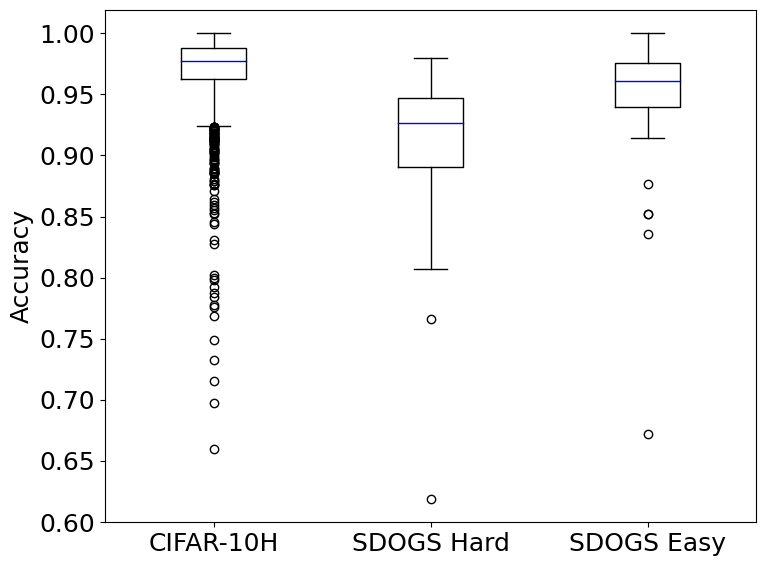

In [9]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8, 6))
plt.boxplot([cifar_accuracy, sdogs_hard_accuracy, sdogs_easy_accuracy], 
            labels=['CIFAR-10H', 'SDOGS Hard', 'SDOGS Easy' ],
           medianprops=dict(color='blue'))
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('boxplot-accuracies.pdf', dpi=300)
plt.show()

# RQ2.  How does the time spent by crowd workers im
pact label certainty?

### CIFAR-10H

In [10]:
reaction_times = nofilter_cifar_df['reaction_time']

# Initialize bin counters
bin_1_count = 0
bin_2_count = 0
bin_3_count = 0

# Iterate through reaction times and count values in each bin
for rt in reaction_times:
    if rt <= 1000:
        bin_1_count += 1
    elif 1000 < rt <= 2500:
        bin_2_count += 1
    elif 2500 < rt:
        bin_3_count += 1

# Output the sizes of each bin
print("Bin (0, 1000]:", bin_1_count)
print("Bin (1000, 2500]:", bin_2_count)
print("Bin (2500, inf):", bin_3_count)

Bin (0, 1000]: 33846
Bin (1000, 2500]: 403865
Bin (2500, inf): 71077


In [11]:
# Define custom bins
custom_bins = [0, 1000, 2500, float('inf')]  # Third bin represents everything above 2500

# Initialize dictionaries to store entropies for each bin and sample IDs for each bin for CIFAR dataset
cifar_entropies = {}
cifar_entropy_ranks = {}

# Get unique sample IDs for CIFAR dataset
cifar_unique_sample_ids = nofilter_cifar_df['cifar10_test_set_idx'].unique()

# Iterate over each sample with tqdm for progress tracking for CIFAR dataset
for cifar_sample_id in tqdm(cifar_unique_sample_ids, desc="Processing CIFAR Samples"):
    # Retrieve data for the current CIFAR sample
    cifar_sample_data = nofilter_cifar_df[nofilter_cifar_df['cifar10_test_set_idx'] == cifar_sample_id]
    
    # Calculate reaction time bins for the current CIFAR sample
    cifar_reaction_time_bins = pd.cut(cifar_sample_data['reaction_time'], bins=custom_bins, labels=[0, 1, 2])
    
    # Initialize a dictionary to store entropies for each bin for CIFAR dataset
    cifar_entropies_per_bin = {}
    
    # Iterate over each reaction time bin for CIFAR dataset
    for cifar_rt_bin, cifar_rt_bin_data in cifar_sample_data.groupby(cifar_reaction_time_bins):
        # Remove missing values and calculate label distribution
        cifar_chosen_labels = cifar_rt_bin_data['chosen_label'].dropna()
        if len(cifar_chosen_labels) == 0:
            continue  # Skip if no labels in this bin
        
        cifar_label_counts = np.bincount(cifar_chosen_labels.astype(int), minlength=10)
        cifar_label_probs = cifar_label_counts / len(cifar_chosen_labels)
        
        # Calculate entropy and store in the dictionary for CIFAR dataset
        cifar_entropies_per_bin[cifar_rt_bin] = entropy(cifar_label_probs, base=len(cifar_label_counts))
    
    # Sort the entropies and obtain the corresponding ranks for CIFAR dataset
    cifar_sorted_entropies = sorted(cifar_entropies_per_bin.values(), reverse=True)
    cifar_ranked_bins = [bin_ for bin_, _ in sorted(cifar_entropies_per_bin.items())]
    
    # Store entropies for each bin for CIFAR dataset
    for cifar_bin, cifar_entropy_value in cifar_entropies_per_bin.items():
        cifar_entropies.setdefault(cifar_bin, []).append(cifar_entropy_value)
    
    # Store sample IDs for each bin for CIFAR dataset
    for cifar_bin in cifar_ranked_bins:
        cifar_entropy_ranks.setdefault(cifar_bin, []).append(cifar_sample_id)

Processing CIFAR Samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
cifar_bin0_entropy = cifar_entropies[0]
cifar_bin1_entropy = cifar_entropies[1]
cifar_bin2_entropy = cifar_entropies[2]

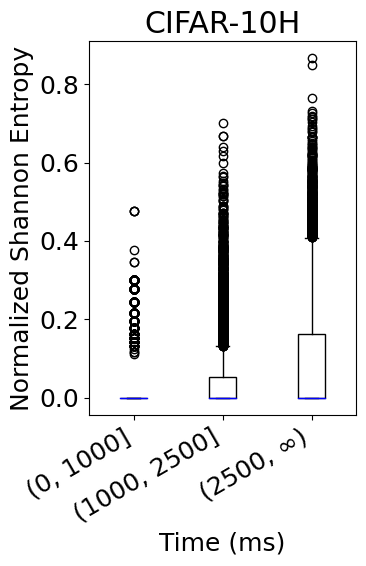

In [13]:
# Data for box plot
cifar_entropy_data = [cifar_bin0_entropy, cifar_bin1_entropy, cifar_bin2_entropy]

# Labels for x-axis in milliseconds
cifar_grp_labels = ['(0, 1000]', '(1000, 2500]', '(2500, ∞)']

# Creating box plot
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(4, 6))  # Adjusted figure size for better display
plt.boxplot(cifar_entropy_data, labels=cifar_grp_labels, patch_artist=True, 
            boxprops=dict(facecolor='white'), widths=0.3, medianprops=dict(color='blue'))
plt.title('CIFAR-10H')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Shannon Entropy')

# Rotate x-axis labels diagonally
plt.xticks(rotation=30, ha='right')  # Adjust rotation angle and alignment as needed
plt.tight_layout()
plt.show()

In [14]:
# Perform Kruskal-Wallis test
kruskal_stat, p_value = kruskal(cifar_bin0_entropy, cifar_bin1_entropy, cifar_bin2_entropy)

# Output the results
print("Kruskal-Statistic:", kruskal_stat)
print("P-value:", p_value)

# Set the significance level
alpha = 0.05
# If Kruskal-Wallis test is significant, perform Dunn's post hoc test
if p_value < alpha:

    print("Reject null hypothesis: There is a statistically significant influence of the bins on entropy values.")
    print("Perform post-hoc test...")
    
    # Convert data to a pandas DataFrame
    cifar_entropy_concat = np.concatenate([cifar_bin0_entropy, cifar_bin1_entropy, cifar_bin2_entropy])
    cifar_bin_labels = ['Bin 0'] * len(cifar_bin0_entropy) + ['Bin 1'] * len(cifar_bin1_entropy) + ['Bin 2'] * len(cifar_bin2_entropy)
    cifar_dunn_df = pd.DataFrame({'Entropy': cifar_entropy_concat, 'Group': cifar_bin_labels})
    
    # Perform Dunn's test with Bonferroni correction for multiple comparisons
    dunn_results = posthoc_dunn(cifar_dunn_df, val_col='Entropy', group_col='Group', p_adjust='bonferroni')
    
    # Output Dunn's test results
    print("Dunn's Test Results:")
    print(dunn_results)
else:
    print("Fail to reject null hypothesis: There is no statistically significant influence of the bins on entropy values.")

Kruskal-Statistic: 2693.409450191599
P-value: 0.0
Reject null hypothesis: There is a statistically significant influence of the bins on entropy values.
Perform post-hoc test...
Dunn's Test Results:
       Bin 0         Bin 1         Bin 2
Bin 0    1.0  0.000000e+00  0.000000e+00
Bin 1    0.0  1.000000e+00  1.572310e-10
Bin 2    0.0  1.572310e-10  1.000000e+00


### SDOGS

In [15]:
# Define categories and map labels to indices
sdogs_categories = ['cairn', 'Border_collie', 'basenji', 'German_shepherd',
                    'Yorkshire_terrier', 'Pekinese', 'Staffordshire_bullterrier',
                    'miniature_poodle', 'Eskimo_dog', 'golden_retriever']

sdogs_label_to_idx = {category: idx for idx, category in enumerate(sdogs_categories)}

# Map labels to indices in the dataframe
sdogs_df['answer_idx'] = sdogs_df['answer'].map(sdogs_label_to_idx)

# Group data by cohort
sdogs_grouped_by_cohort = sdogs_df.groupby('viewtime')

# Initialize dictionaries to store entropies and entropy ranks for each cohort group
sdogs_cohort_entropies = {}
sdogs_cohort_entropy_ranks = {}

# Apply the function to each group
for sdogs_cohort, sdogs_group_data in sdogs_grouped_by_cohort:
    # Pivot DataFrame to have each row represent a sample and each column represent an annotator
    sdogs_pivoted_df = sdogs_group_data.pivot(index='test_qid', columns='participant_id', values='answer_idx')
    
    # Calculate entropy for each sample
    sdogs_sample_entropies = []
    for _, sdogs_row in sdogs_pivoted_df.iterrows():
        if sdogs_row.isnull().all():
            continue  # Skip if no labels in this row

        sdogs_label_counts = np.bincount(sdogs_row.dropna().astype(int), minlength=10)
        sdogs_label_probs = sdogs_label_counts / len(sdogs_row.dropna())
        
        # Calculate entropy and append to the list
        sdogs_sample_entropies.append(entropy(sdogs_label_probs, base=len(sdogs_label_counts)))

    # Rank samples by entropy
    sdogs_sorted_entropies = np.sort(sdogs_sample_entropies)[::-1]
    sdogs_ranked_samples = np.argsort(sdogs_sample_entropies)[::-1]

    # Store entropies and ranks for each cohort
    sdogs_cohort_entropies[sdogs_cohort] = sdogs_sorted_entropies
    sdogs_cohort_entropy_ranks[sdogs_cohort] = sdogs_ranked_samples

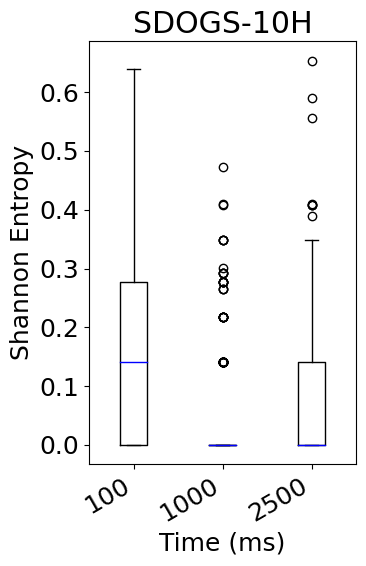

In [16]:
sdogs_bin0_entropy = sdogs_cohort_entropies[100]
sdogs_bin1_entropy = sdogs_cohort_entropies[1000]
sdogs_bin2_entropy = sdogs_cohort_entropies[2500]

# Data for box plot
sdogs_entropy_data = [sdogs_bin0_entropy, sdogs_bin1_entropy, sdogs_bin2_entropy]
sdogs_grp_labels = ['100', '1000', '2500']

# Creating box plot
plt.figure(figsize=(4, 6))
plt.boxplot(sdogs_entropy_data, labels=sdogs_grp_labels, widths=0.3, medianprops=dict(color='blue'))
plt.title('SDOGS-10H')
plt.xlabel('Time (ms)') 
plt.ylabel('Shannon Entropy')
plt.xticks(rotation=30, ha='right')  # Adjust rotation angle and alignment as needed
plt.tight_layout()
plt.savefig('sdogs10h-entropies.pdf', dpi=300)
plt.show()

In [17]:
# Perform Kruskal-Wallis test
kruskal_stat, p_value = kruskal(sdogs_bin0_entropy, sdogs_bin1_entropy, sdogs_bin2_entropy)

# Output the results
print("Kruskal-Statistic:", kruskal_stat)
print("P-value:", p_value)

# Set the significance level
alpha = 0.05
# If Kruskal-Wallis test is significant, perform Dunn's post hoc test
if p_value < alpha:
    print("Reject null hypothesis: There is a statistically significant influence of the bins on entropy values.")
    print("Perform post-hoc test...")
    # Assuming you have the entropy values stacked in a single array and corresponding group labels in another array
    sdogs_entropy_concat = np.concatenate([sdogs_bin0_entropy, sdogs_bin1_entropy, sdogs_bin2_entropy])
    sdogs_bin_labels = ['Bin 0'] * len(sdogs_bin0_entropy) + ['Bin 1'] * len(sdogs_bin1_entropy) + ['Bin 2'] * len(sdogs_bin2_entropy)
    sdogs_dunn_df = pd.DataFrame({'value': sdogs_entropy_concat, 'bin': sdogs_bin_labels})
    # Perform Dunn's test with Bonferroni correction for multiple comparisons
    dunn_results = posthoc_dunn(sdogs_dunn_df, val_col='value', group_col='bin', p_adjust='bonferroni')
    
    # Output Dunn's test results
    print("Dunn's Test Results (Bonferroni corrected p-values):")
    print(dunn_results)
else:
    print("Fail to reject null hypothesis: There is no statistically significant influence of the bins on entropy values.")

Kruskal-Statistic: 93.75574548744328
P-value: 4.377221704799089e-21
Reject null hypothesis: There is a statistically significant influence of the bins on entropy values.
Perform post-hoc test...
Dunn's Test Results (Bonferroni corrected p-values):
              Bin 0         Bin 1         Bin 2
Bin 0  1.000000e+00  5.366969e-20  5.478731e-12
Bin 1  5.366969e-20  1.000000e+00  7.782412e-02
Bin 2  5.478731e-12  7.782412e-02  1.000000e+00


## Combine plots

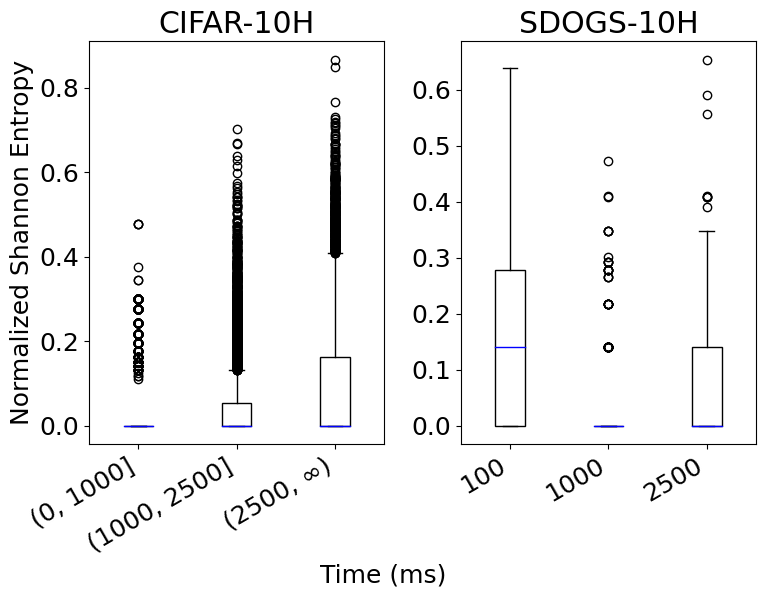

In [18]:
# Create subplots
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Plot for CIFAR-10H
axs[0].boxplot(cifar_entropy_data, labels=cifar_grp_labels, patch_artist=True, 
               boxprops=dict(facecolor='white'), widths=0.3, medianprops=dict(color='blue'))
axs[0].set_title('CIFAR-10H')
axs[0].set_ylabel('Normalized Shannon Entropy')
axs[0].grid(False)
axs[0].tick_params(axis='x', rotation=30)  # Rotate x-axis labels diagonally
axs[0].set_xticklabels(cifar_grp_labels, rotation=30, ha='right')

# Plot for SDOGS-10H
axs[1].boxplot(sdogs_entropy_data, labels=sdogs_grp_labels, patch_artist=True, 
               boxprops=dict(facecolor='white'), widths=0.3, medianprops=dict(color='blue'))
axs[1].set_title('SDOGS-10H')
axs[1].grid(False)
axs[1].tick_params(axis='x', rotation=30)  # Rotate x-axis labels diagonally
axs[1].set_xticklabels(sdogs_grp_labels, rotation=30, ha='right')

# Adding common x-label
fig.text(0.5, 0.0, 'Time (ms)', ha='center')

plt.tight_layout()
plt.savefig('entropies.pdf', dpi=300)
plt.show()

# RQ3. What is the trade-off between data quality and varying time limits

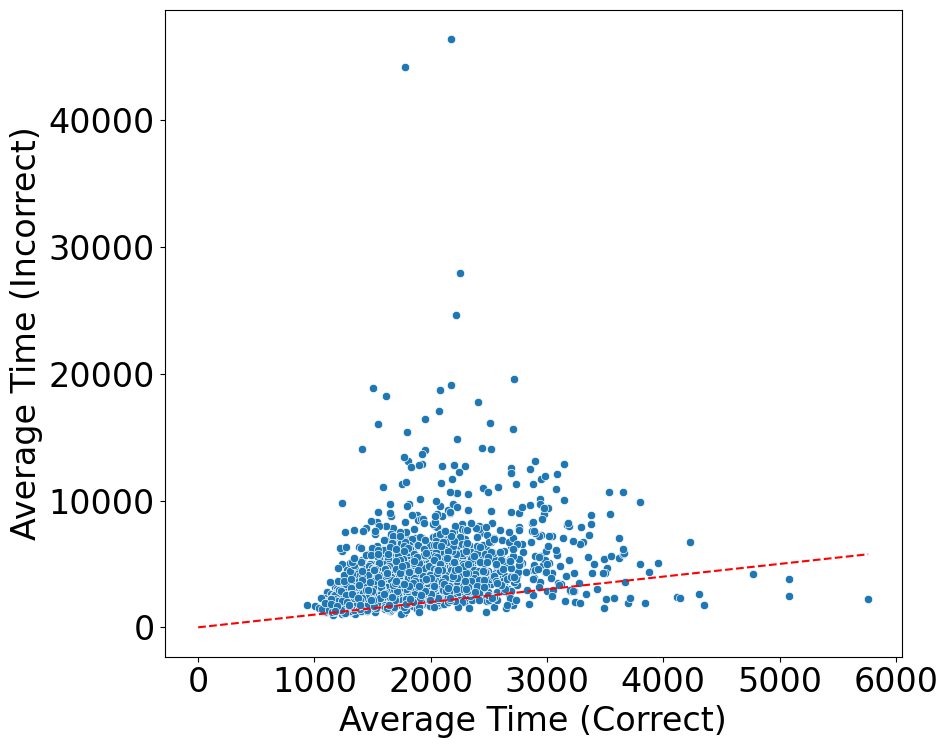

Overall Mean Reaction Time for Incorrect Answers: 3755.0947701464893
Overall Mean Reaction Time for Correct Answers: 1828.57578105598
Correlation between Mean Reaction Time (Correct Answers) and Mean Reaction Time (Incorrect Answers): 0.3599160645903019


In [19]:
# Calculate mean reaction time for each annotator and their correctness
cifar_mean_reaction_time = nofilter_cifar_df.groupby(['annotator_id', 'correct_guess'])['reaction_time'].mean().reset_index()

# Filter for rows where correct_guess is 0 (incorrect)
cifar_incorrect_answers = cifar_mean_reaction_time[cifar_mean_reaction_time['correct_guess'] == 0].rename(columns={'reaction_time': 'reaction_time_wrong'})

# Filter for rows where correct_guess is 1 (correct)
cifar_correct_answers = cifar_mean_reaction_time[cifar_mean_reaction_time['correct_guess'] == 1].rename(columns={'reaction_time': 'reaction_time_correct'})

# Merge the two mean reaction time dataframes on annotator_id
cifar_correct_incorrect_df = pd.merge(cifar_incorrect_answers, cifar_correct_answers, on='annotator_id', how='inner')

# Plot the results
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(10, 8))
sns.scatterplot(x='reaction_time_correct', y='reaction_time_wrong', data=cifar_correct_incorrect_df)
plt.plot([0, cifar_correct_incorrect_df['reaction_time_correct'].max()], 
         [0, cifar_correct_incorrect_df['reaction_time_correct'].max()], 
         linestyle='--', color='red')
plt.xlabel('Average Time (Correct)')
plt.ylabel('Average Time (Incorrect)')
plt.tight_layout()
plt.savefig('correct-vs-incorrect.pdf', dpi=300)
plt.show()

# Calculate correlation
correlation = np.corrcoef(cifar_correct_incorrect_df['reaction_time_correct'], cifar_correct_incorrect_df['reaction_time_wrong'])[0, 1]

print("Overall Mean Reaction Time for Incorrect Answers:", cifar_incorrect_answers['reaction_time_wrong'].mean())
print("Overall Mean Reaction Time for Correct Answers:", cifar_correct_answers['reaction_time_correct'].mean())
print("Correlation between Mean Reaction Time (Correct Answers) and Mean Reaction Time (Incorrect Answers):", correlation)

In [20]:
### Count the number of annotators below and above the diagonal line
below_diagonal = cifar_correct_incorrect_df[cifar_correct_incorrect_df['reaction_time_wrong'] < 
                                            cifar_correct_incorrect_df['reaction_time_correct']].shape[0]
above_diagonal = cifar_correct_incorrect_df[cifar_correct_incorrect_df['reaction_time_wrong'] > 
                                            cifar_correct_incorrect_df['reaction_time_correct']].shape[0]

print("Number of annotators below the diagonal line:", below_diagonal)
print("Number of annotators above the diagonal line:", above_diagonal)

Number of annotators below the diagonal line: 118
Number of annotators above the diagonal line: 2425


Majority of annotators spend more time on average on trials they got incorrect on anyways.

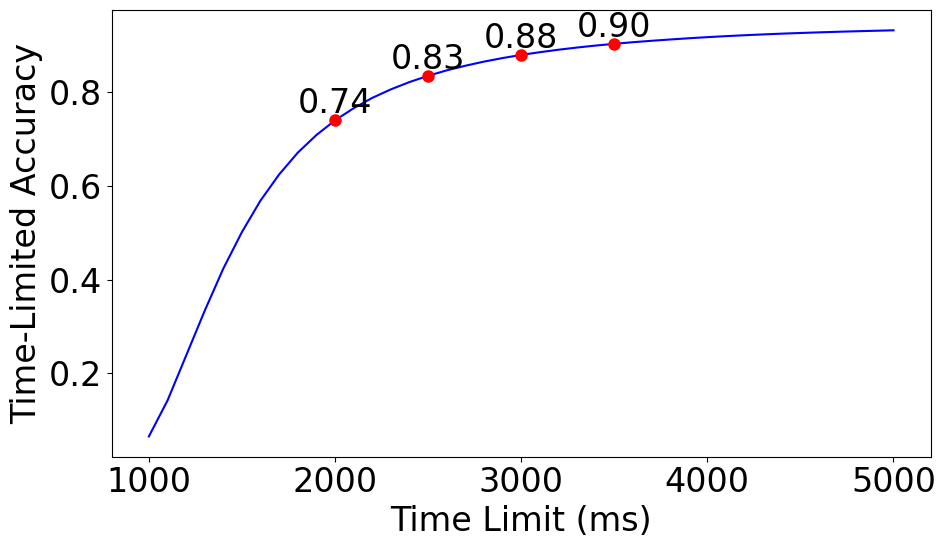

In [21]:
# Define the range of time limits (in milliseconds)
time_limits = np.arange(1000, 5100, 100)

# Initialize a list to store overall accuracies
cifar_overall_accuracies = []

for limit in time_limits:
    # Create a copy of the original data to avoid modifying the original dataframe
    nofilter_cifar_df_copy = nofilter_cifar_df.copy()
    
    # Update correctness value for reaction times beyond the limit
    nofilter_cifar_df_copy.loc[nofilter_cifar_df_copy['reaction_time'] > limit, 'correct_guess'] = 0
    
    # Calculate overall accuracy
    cifar_overall_accuracy = nofilter_cifar_df_copy['correct_guess'].mean()
    
    # Append overall accuracy to the list
    cifar_overall_accuracies.append(cifar_overall_accuracy)

# Plot
plt.figure(figsize=(10, 6))

# Plot overall accuracy
plt.plot(time_limits, cifar_overall_accuracies, color='blue', label='Overall Accuracy', linestyle='-')
plt.xlabel('Time Limit (ms)')
plt.ylabel('Time-Limited Accuracy')
# plt.title('Overall Accuracy for Different Time Limits')
# plt.grid(True)

# Add points and annotate the accuracy at specific time limits
for limit, accuracy in zip(time_limits, cifar_overall_accuracies):
    if limit in [2000, 2500, 3000, 3500]:
        plt.plot(limit, accuracy, marker='o', markersize=8, color='red')  # Add point
        plt.text(limit, accuracy, f'{accuracy:.2f}', ha='center', va='bottom')  # Annotate accuracy

# Show plot
# plt.legend()
plt.tight_layout()
plt.savefig('time-limited-accuracy.pdf', dpi=300)
plt.show()

# RQ4: Which images are more difficult under time limit?

In [22]:
# Manually annotated image ids categorised by image types that participants reflected wanting more time on in our survey
diff_ft_ids = {}
diff_ft_ids['non-dog'] = [603, 696, 17379, 615, 613, 19677, 6584, 17180, 10023, 10018, 16512, 19754, 6523, 10033, 10091, 7576, 14434, 10117, 16575, 14464, 10060, 10142, 16552, 14365, 730, 14441, 708, 14456, 6547]
diff_ft_ids['multi-dog'] = [17180, 7527, 16573, 16602, 10099, 16623, 10077, 17279, 16516, 16572]
diff_ft_ids['puppy'] = [5192, 14447, 19760, 6579, 17253, 714, 6541, 650, 19684, 16646, 14018, 14342, 680, 6665, 719, 6658, 10080, 713, 7491, 14019, 16508, 13887, 6597, 13966, 595]
diff_ft_ids['small'] = [603, 17253, 16602, 19677, 10023, 10018, 16601, 19700, 17275, 14022, 19666, 19691, 731, 17320, 14359, 17288]
diff_ft_ids['low-light'] = [19677, 16573, 6584, 6579, 17180, 13954, 5205, 19712, 7538, 7477, 636, 6540, 6598, 5226, 19653, 17256, 7528, 13956, 6553, 17373, 6544]
diff_ft_ids['dark-dogs'] = [13954, 5205, 19712, 7538, 7477, 16601, 19700, 7615, 5192, 14447, 19760, 7527, 5278, 5138, 5211, 19636, 5232, 13946, 7606, 14385, 5206, 5129, 14379, 5177, 5258, 5265, 14432, 5247, 5225, 13925, 14419, 17268, 5162, 19751, 5145, 5204, 19662, 13907, 7601, 5257, 14007, 19719, 5188, 19766]

In [23]:
def sdogs_easy_correctness(row):
    if row['stanford_label'] == 'cairn':
        return row['answer'] in ['cairn', 'Yorkshire_terrier']
    elif row['stanford_label'] == 'Yorkshire_terrier':
        return row['answer'] in ['cairn', 'Yorkshire_terrier']
    else:
        return row['correct']

sdogs_df['sdogs_easy_correct'] = sdogs_df.apply(sdogs_easy_correctness, axis=1)

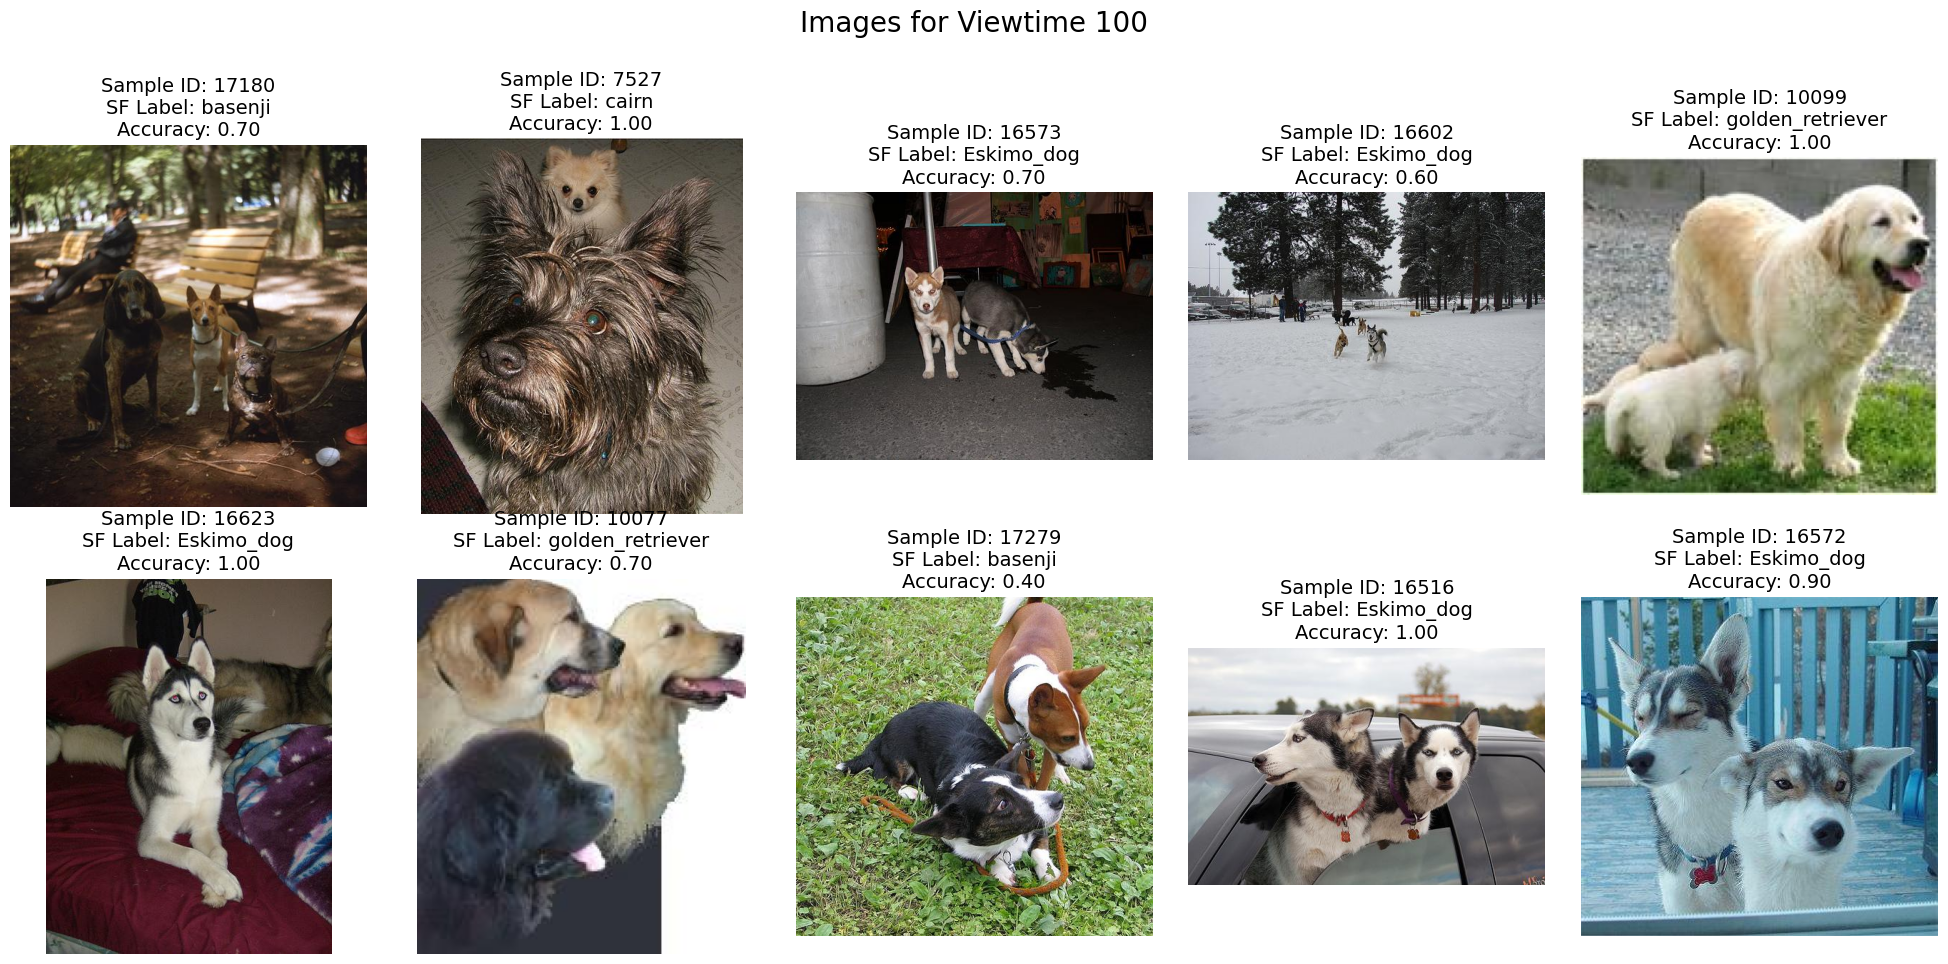

Average Accuracy: 0.8000


In [24]:
# Load Stanford Dogs dataset using ImageFolder
data_dir = "../StanfordDogs_Dataset"
dataset = datasets.ImageFolder(data_dir)

# Create DataLoader for the dataset
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Function to display images for given sample_ids
def display_images(viewtime, sample_ids, dataset, sdogs_df):
    num_images = len(sample_ids)
    num_cols = min(num_images, 5)  # Display at most 5 images per row
    num_rows = (num_images + num_cols - 1) // num_cols
    
    plt.figure(figsize=(20, 10))  # Larger figure size
    
    plt.suptitle(f'Images for Viewtime {viewtime}', fontsize=20)  # Increase title fontsize
    
    # Filter the dataframe to include only the data for the specified viewtime
    viewtime_data = sdogs_df[sdogs_df['viewtime'] == viewtime]
    
    total_accuracy = 0
    
    for i, sample_id in enumerate(sample_ids):
        image_path = dataset.samples[sample_id][0]
        image = plt.imread(image_path)
        
        # Get label information
        label = viewtime_data.loc[viewtime_data['stanford_sampleid'] == sample_id, 'stanford_label'].values[0]
        
        # Compute accuracy for the current sample_id
        num_correct = viewtime_data.loc[(viewtime_data['stanford_sampleid'] == sample_id) & (viewtime_data['sdogs_easy_correct'] == 1)].shape[0]
        num_annotators = viewtime_data.loc[viewtime_data['stanford_sampleid'] == sample_id].shape[0]
        accuracy = num_correct / num_annotators if num_annotators > 0 else 0
        
        total_accuracy += accuracy
        
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image)
        plt.title(f'Sample ID: {sample_id}\nSF Label: {label}\nAccuracy: {accuracy:.2f}', fontsize=14)  # Increase title fontsize
        plt.axis('off')
    
    # Calculate average accuracy
    average_accuracy = total_accuracy / num_images
    
    plt.tight_layout()
    plt.show()
    
    print(f'Average Accuracy: {average_accuracy:.4f}')  # Print average accuracy

# Example usage:
# View images with annotated property, and average accuracy within a cohort
sample_ids_to_display = diff_ft_ids['multi-dog'] # Replace key with chosen image prop
viewtime = 100  # Replace with chosen viewtime cohort
display_images(viewtime, sample_ids_to_display, dataset, sdogs_df)

In [25]:
sdogs_categories = ['cairn', 'Border_collie', 'basenji', 'German_shepherd',
                    'Yorkshire_terrier', 'Pekinese', 'Staffordshire_bullterrier',
                    'miniature_poodle', 'Eskimo_dog', 'golden_retriever']

sdogs_label_to_idx = {category: idx for idx, category in enumerate(sdogs_categories)}

# Calculate entropy for each group
entropy_list = []

# Group by viewtime
sdogs_grouped_by_cohort = sdogs_df.groupby('viewtime')

for sdogs_cohort, sdogs_group_data in sdogs_grouped_by_cohort:
    # Group by stanford_sampleid within each viewtime group
    grouped_by_sample_id = sdogs_group_data.groupby('stanford_sampleid')
    for sample_id, sample_data in grouped_by_sample_id:
        # Skip if there is no data for this sample ID
        if len(sample_data) == 0:
            continue
        # Map the answers to their corresponding indices
        label_indices = sample_data['answer'].map(sdogs_label_to_idx).astype(int)
        # Count the occurrences of each label
        label_counts = np.bincount(label_indices, minlength=len(sdogs_categories))
        # Calculate the probabilities of each label
        label_probs = label_counts / len(sample_data)
        # Calculate the entropy of the label distribution
        sample_entropy = entropy(label_probs, base=len(sdogs_categories))
        # Append the results to the list
        entropy_list.append({'viewtime': sdogs_cohort, 'stanford_sampleid': sample_id, 'entropy': sample_entropy})

# Create a DataFrame from the entropy list
sdogs_entropy_df = pd.DataFrame(entropy_list)

# Sort by entropy values within each viewtime group
sorted_samples_per_bin = sdogs_entropy_df.groupby('viewtime').apply(lambda x: x.sort_values(by='entropy', ascending=False))

# Get the list of stanford_sampleids in order of highest entropy to lowest for each viewtime group
sampleids_ordered_by_entropy = sorted_samples_per_bin.groupby(level=0)['stanford_sampleid'].apply(list)

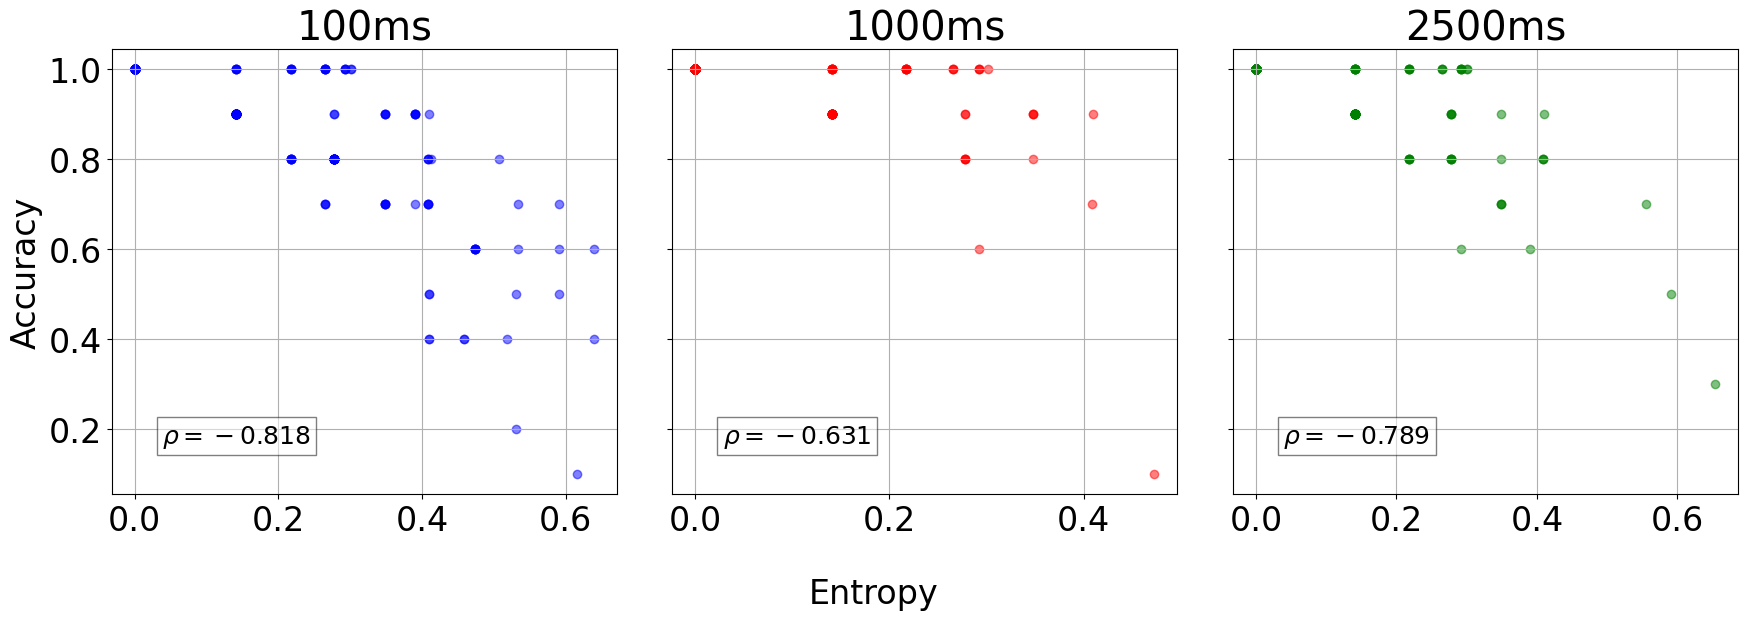

In [26]:
# Function to plot accuracy vs. entropy for a specific time cohort
def plot_accuracy_entropy(ax, viewtime, accuracies, entropies, color):
    ax.scatter(entropies, accuracies, alpha=0.5, color=color)
    ax.set_title(f"{viewtime}ms")
    ax.grid(True)
    
    # Compute correlation coefficient
    corr_coefficient, _ = pearsonr(entropies, accuracies)
    
    # Display correlation coefficient
    ax.text(0.1, 0.1, fr'$\rho = {corr_coefficient:.3f}$', transform=ax.transAxes, ha='left', va='bottom', fontsize=18, color='black', bbox=dict(facecolor='white', alpha=0.5))

# Function to compute accuracy and entropy for each time cohort
def compute_accuracy_entropy(sdogs_df, sorted_samples_per_bin, viewtime):
    accuracies = []
    entropies = []
    
    # Filter data for the specific viewtime
    viewtime_data = sorted_samples_per_bin[sorted_samples_per_bin['viewtime'] == viewtime]
    
    for index, row in viewtime_data.iterrows():
        # Get sample ID
        sample_id = row['stanford_sampleid']
        
        # Compute accuracy for the current sample_id
        num_correct = sdogs_df.loc[(sdogs_df['viewtime'] == viewtime) & (sdogs_df['stanford_sampleid'] == sample_id) & (sdogs_df['sdogs_easy_correct'] == 1)].shape[0]
        num_annotators = sdogs_df.loc[(sdogs_df['viewtime'] == viewtime) & (sdogs_df['stanford_sampleid'] == sample_id)].shape[0]
        accuracy = num_correct / num_annotators if num_annotators > 0 else 0
        accuracies.append(accuracy)
        
        # Get entropy value for the current sample_id
        entropy = row['entropy']
        entropies.append(entropy)
    
    return accuracies, entropies

# Colors for each plot
colors = ['blue', 'red', 'green']

# Compute accuracy and entropy for each time cohort and plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
plt.subplots_adjust(wspace=0.3)

for i, viewtime in enumerate(sorted_samples_per_bin['viewtime'].unique()):
    accuracies, entropies = compute_accuracy_entropy(sdogs_df, sorted_samples_per_bin, viewtime)
    plot_accuracy_entropy(axs[i], viewtime, accuracies, entropies, color=colors[i])

# Add a centered x-axis label below all subplots
fig.text(0.5, -0.05, 'Entropy', ha='center')

# Add a y-axis label only to the leftmost subplot
axs[0].set_ylabel('Accuracy')

plt.tight_layout()
plt.savefig('accuracy-entropy.pdf', dpi=300)
plt.show()

# RQ6: How does a view time limit affect the satisfac
tion/motivation of crowd workers?

Does accuracy drop over the duration of the task?

In [27]:
# Group data by 'test_qid', 'viewtime', and calculate the sum of 'correct' for each group
sdogs_correct_df = sdogs_df.groupby(['test_qid', 'viewtime'])['correct'].sum().reset_index()

sdogs_correct_df['cumsum'] = sdogs_correct_df.groupby(['viewtime'])['correct'].cumsum()

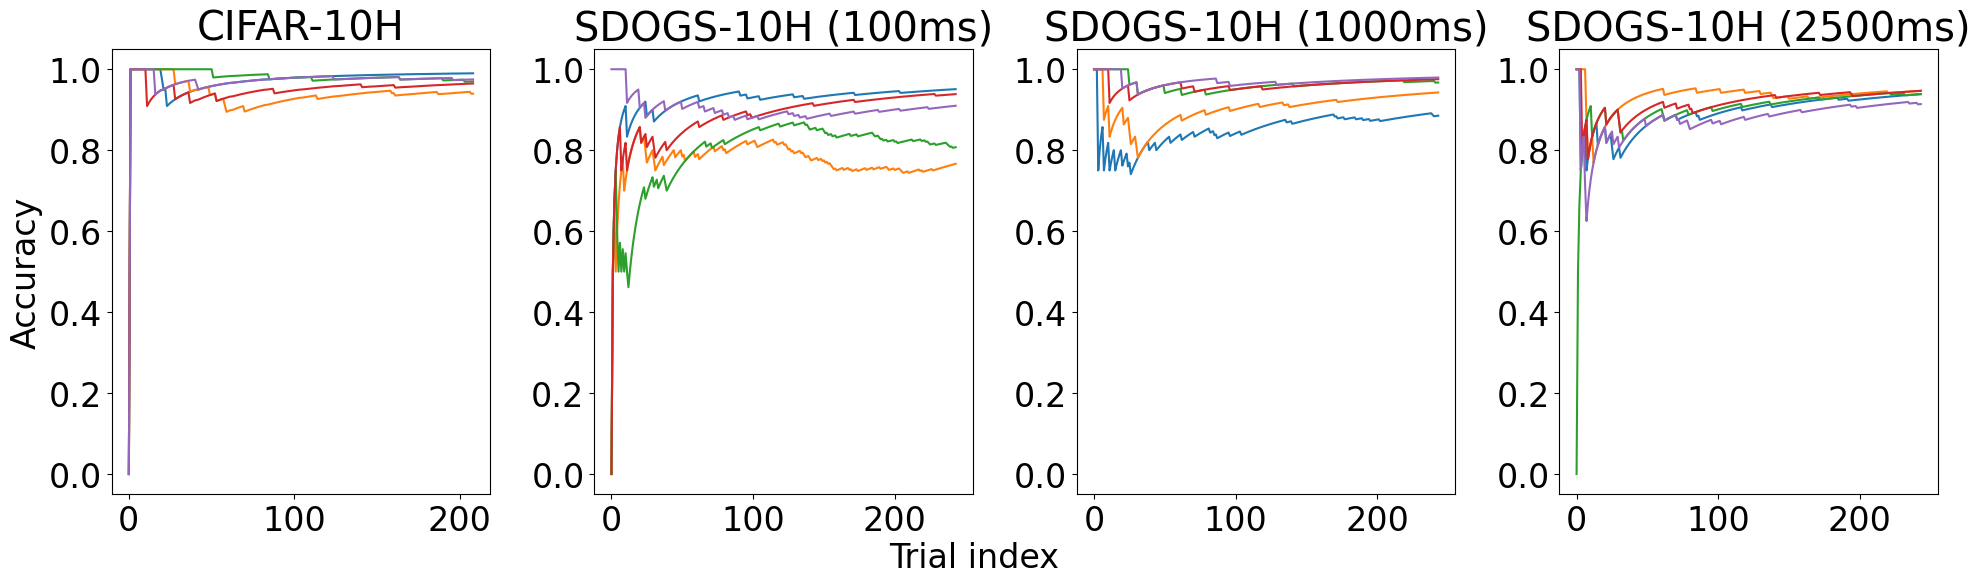

In [29]:
np.random.seed(100)

# Select a sample of 10 annotators for CIFAR-10H
sampled_annotators = nofilter_cifar_df['annotator_id'].sample(n=5).tolist()

plt.figure(figsize=(20, 6))  # Adjust the figure size to accommodate plots in a row

# Plotting CIFAR-10H data
plt.subplot(1, 4, 1)  # Adjust the number of columns according to the number of plots
for annotator_id in sampled_annotators:
    annotator_data = nofilter_cifar_df[nofilter_cifar_df['annotator_id'] == annotator_id]
    correct_answers = annotator_data['correct_guess']
    trial_count = len(annotator_data)
    accuracy = [(correct_answers.iloc[:i].sum() / i) if i > 0 else 0 for i in range(trial_count)]
    plt.plot(annotator_data['trial_index'], accuracy, label=f'Annotator {annotator_id}')
plt.title('CIFAR-10H')
plt.ylabel('Accuracy')
plt.ylim([-0.05, 1.05])

np.random.seed(100)

# Group data by 'viewtime' for SDOGS-10H
viewtime_groups = sdogs_df.groupby('viewtime')

# Iterate over viewtime cohorts for SDOGS-10H
subplot_idx = 2
for viewtime, viewtime_data in viewtime_groups:
    # Sample 5 participants for each viewtime cohort
    sampled_participants = viewtime_data['participant_id'].sample(n=5)

    plt.subplot(1, 4, subplot_idx)
    subplot_idx += 1
    
    # Plot cumulative accuracy for each participant at every test_qid
    for participant_id in sampled_participants:
        participant_data = viewtime_data[viewtime_data['participant_id'] == participant_id]
        accuracy = []
        correct_answers = 0
        total_questions = 0
        for qid in participant_data['test_qid']:
            total_questions += 1
            correct_answer = participant_data[participant_data['test_qid'] == qid]['correct'].values[0]
            if correct_answer:
                correct_answers += 1
            accuracy.append(correct_answers / total_questions)
        
        # Plot accuracy for the annotator
        plt.plot(range(len(accuracy)), accuracy)
    
    # Customize plot
    plt.title(f'SDOGS-10H ({viewtime}ms)')
    if subplot_idx == 2:  # Use only one x-label for the first subplot
        plt.ylabel('Accuracy')
    plt.ylim([-0.05, 1.05])

# Add text "Trial index" at the bottom of all plots in the center
plt.figtext(0.5, 0.01, 'Trial index', ha='center')

plt.tight_layout()
plt.savefig('accuracy-over-trial.pdf', dpi=300)
plt.show()

Any pattern in PANAS scores?

In [ ]:
# Grouping data by viewtime and calculating mean of PosAffect and NegAffect
grouped_data = sdogs_df.groupby('viewtime').agg({'PosAffect': 'mean', 'NegAffect': 'mean'}).reset_index()

# Plotting
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(10, 6))
plt.plot(grouped_data['viewtime'], grouped_data['PosAffect'], label='PosAffect', marker='o', linewidth=2)
plt.plot(grouped_data['viewtime'], grouped_data['NegAffect'], label='NegAffect', marker='o', color='red', linewidth=2)
plt.xlabel('View Time Cohort')
plt.ylabel('Average Affect')
plt.xticks([100, 1000, 2500])  # Specify the x-axis ticks
plt.grid(linestyle='dotted')
plt.legend(ncol=2, loc=9) # 9 means top center
plt.tight_layout()
plt.savefig('affect-scores.pdf', dpi=300)
plt.show()

In [ ]:
# Calculate the difference between PosAffect and NegAffect for each participant
sdogs_df['AffectDifference'] = sdogs_df['PosAffect'] - sdogs_df['NegAffect']

# Perform Mann-Whitney U test for each pair of viewtime groups
groups = sdogs_df['viewtime'].unique()
mwu_results = {}
for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        group1 = sdogs_df[sdogs_df['viewtime'] == groups[i]]['AffectDifference']
        group2 = sdogs_df[sdogs_df['viewtime'] == groups[j]]['AffectDifference']
        result = mannwhitneyu(group1, group2)
        mwu_results[f'{groups[i]} vs {groups[j]}'] = result

# Perform Dunn post hoc test
dunn_results = sp.posthoc_dunn(sdogs_df, val_col='AffectDifference', group_col='viewtime')

# Print Mann-Whitney U test results
print("Mann-Whitney U test results:")
for comparison, result in mwu_results.items():
    print(f"{comparison}: U-statistic = {result.statistic}, p-value = {result.pvalue}")

# Print Dunn post hoc test results
print("\nDunn post hoc test results:")
print(dunn_results)